In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import re
import json
from glob import glob

import mcmc as am

## Functions

In [45]:
def chain_file_to_stats_df(filename):
    """
    Load an MCMC chain stored in a CSV file directly into 
    a summary statistics DataFrame.
    """
    # Get features names:
    match = re.search('[A-Z]+\-[A-Z]+', filename)
    if match is not None:
        pair = match[0].split('-')
    
    df = am.create_stats_summary_df(pd.read_csv(filename), pair[0], pair[1])
    
    return df

In [46]:
def stat_significant_df(stats_df, global_significance):
    """
    """
    
    # Select statistically significant data:
    relevant_df = stats_df.loc[stats_df['s p-value'] < global_significance].sort_values('sP(A|B)').copy()
    
    # Create an ID for the sentiment pair:
    relevant_df['pair_id'] = relevant_df['A'] + relevant_df['B']
    relevant_df['pair_id'].where(relevant_df['A'] < relevant_df['B'], relevant_df['B'] + relevant_df['A'], inplace=True)

    # Add columns for plotting (label and columns):
    relevant_df['label'] = relevant_df['B'] + ' -> ' + relevant_df['A']
    relevant_df.loc[relevant_df['sP(A|B)'] < 0, 'color'] = 'firebrick'
    relevant_df.loc[relevant_df['sP(A|B)'] > 0, 'color'] = 'royalblue'
        
    return relevant_df

In [47]:
def sel_one_way(relevant_df):
    """
    When sP(A|B) is significant, sP(B|A) is too.
    Select the largest effect of the two.
    """
    
    # If one way is statistically significant, the other one is as well.
    assert set(relevant_df['A'] + relevant_df['B']) == set(relevant_df['B'] + relevant_df['A'])

    # Select just the strongest of the sentiment pairs:
    one_way_df = relevant_df.loc[relevant_df['sP(A|B)'].abs().sort_values(ascending=False).index].copy()
    one_way_df = one_way_df.drop_duplicates(subset='pair_id', keep='first').sort_values('sP(A|B)')
    
    return one_way_df

In [48]:
def plot_prob_gain(relevant_df):

    pl.barh(relevant_df['label'], relevant_df['sP(A|B)'], left=relevant_df['P(A)'], color=relevant_df['color'], alpha=0.6)
    #pl.axvline(0, color='0.7', linewidth=1)
    pl.axvline(0.5, color='0.7', linestyle='--', linewidth=1)
    pl.errorbar(relevant_df['P(A|B)'], relevant_df['label'], xerr=relevant_df['dev P(A|B)'], fmt='none', ecolor=relevant_df['color'])
    pl.xlim([0,1])
    pl.xlabel('Probability')


In [49]:
def annotation_matrix_show(df, cmap, label, fignum=None, vmin=None, vmax=None):
    """
    Create a colormap for a matrix.
    
    Parameters
    ----------
    df : DataFrame
        Matrix to plot. It is expected that all columns contains numbers.
    cmap : str
        Matplotlib colormap to be used (e.g. 'Greens', 'Coolwarm').
    label : str
        Label for the colorbar (i.e. what the numbers in the matrix correspond
        to).
    fignum : int or None
        The number of the figure in which to create the plot (if the Figure 
        was already created). If None, create a new Figure.
    vmin : float or None
        Mininum value in the color scale.
    vmax : float or None
        Maximum value in the color scale.
    """
    cols = df.columns
    rows = df.index
    
    pl.matshow(df, cmap=cmap, vmin=vmin, vmax=vmax, fignum=fignum)
    pl.xticks(ticks=range(len(cols)), labels=cols, rotation=90)
    pl.yticks(ticks=range(len(rows)), labels=rows)
    ax = pl.gca()
    pl.tick_params(labelsize=10)
    ax.xaxis.set_label_position('top')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = pl.colorbar(cax=cax)
    cbar.ax.tick_params(labelsize=10)
    cbar.ax.set_ylabel(label, fontsize=11)
    
    pl.sca(ax)

## Load data

In [6]:
emotion_cols = ['ABORRECIMENTO', 'ADMIRACAO', 'ALEGRIA', 'ALIVIO', 'AMOR', 'APROVACAO', 'COMPRAIXAO', 'CONFUSAO', 'CURIOSIDADE', 'DECEPCAO', 
                'DESAPROVACAO', 'DESEJO', 'DIVERSAO', 'ENTUSIASMO', 'GRATIDAO', 'INVEJA', 'LUTO', 'MEDO', 'NERVOSISMO', 'EMONEUTRO', 'NOJO',
                'ORGULHO', 'OTIMISMO', 'RAIVA', 'REMORSO', 'SAUDADE', 'SCHADENFREUDE', 'SURPRESA', 'TRISTEZA', 'VERGONHA']

In [ ]:
# List chains:
emo_chain_files   = sorted(glob('../data/chains/emo/*.csv'))

# Gets statistical summary from chains:
emo_stats_df   = pd.concat([chain_file_to_stats_df(f) for f in emo_chain_files], ignore_index=True)

In [56]:
# Load categories translation:
with open('../data/cleaned/translations_emo.json', 'r') as f:
    emo_translation = json.load(f)

### Select statistically relevant results

In [15]:
single_significance = 0.02
n_classes = len(emotion_cols)
n_comparisons = n_classes * (n_classes - 1) / 2
global_significance = single_significance / n_comparisons

In [61]:
emo_relevant_df = stat_significant_df(emo_stats_df, global_significance)
one_way_df = sel_one_way(emo_relevant_df)

## Analysing chains

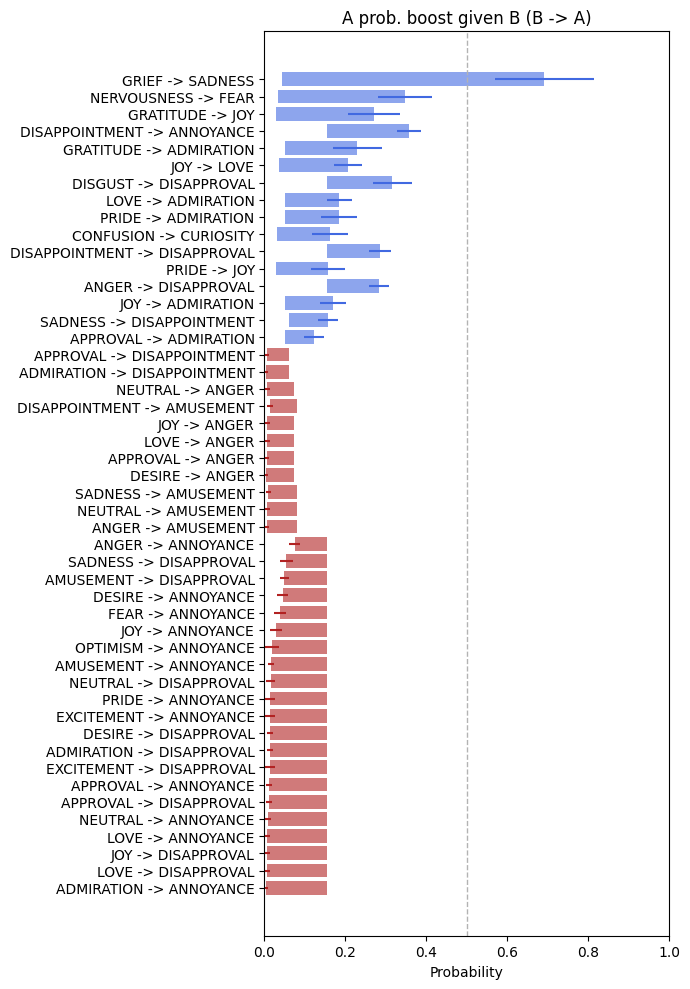

In [62]:
pl.figure(figsize=(7,10))
one_way_df['A'] = one_way_df['A'].map(emo_translation)
one_way_df['B'] = one_way_df['B'].map(emo_translation)
one_way_df['label'] = one_way_df['B'] + ' -> ' + one_way_df['A']
plot_prob_gain(one_way_df)
pl.title('A prob. boost given B (B -> A)')
pl.tight_layout()
#pl.savefig('plots/probabity-gain-from-conditional_emotions.png')
pl.show()